# Homework 2 - Generalized Hough Transform

## Theory

**Task 1:**
( ii )

**Task 2:**
( ? )

## Programming

Find object in an image using a template:  
![title](data/template.jpg)
![title](data/query.jpg)

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
import cv2
import utils
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances

def nonMaxSuprression(img, d=5):
    """
    Given an image set all values to 0 that are not
    the maximum in its (2d+1,2d+1)-window

    Parameters
    ----------
    img : ndarray
        an image
    d : int
        for each pixels consider the surrounding (2d+1,2d+1)-window  

    Returns
    -------
    result : ndarray

    """
    rows,cols = img.shape
    result = np.zeros((rows,cols))
    # TODO
    # iterate over pixels
    # iterate over (2d+1,2d+1) neighborhood window
    # supress non-maxima to 0
    # store results in new array
    
    for i in range(rows):
        for j in range(cols):
            i0 = max(i - d, 0)
            j0 = max(j - d, 0)
            i1 = min(i + d + 1, rows)
            j1 = min(j + d + 1, cols)
            window = img[i0:i1, j0:j1]
            max_value = np.max(window)
            if img[i, j] == max_value:
                result[i, j] = max_value
    
    return result

def calcBinaryMask(img, thresh = 0.3):
    """
    Compute the gradient of an image and compute a binary mask
    based on the threshold. Corresponds to O^B in the slides.

    Parameters
    ----------
    img : ndarray
        an image
    thresh : float
        A threshold value. The default is 0.3.

    Returns
    -------
    binary : ndarray
        A binary image.

    """

    # TODO: 
    # -compute gradients
    # -threshold gradients 
    # -return binary mask

    rows,cols = img.shape
    O_B= np.zeros((rows,cols))

    O_I= utils.calcDirectionalGrad(img)
    O_I_norm= np.abs(O_I)
    threshold= thresh * np.max(O_I_norm)
    mask= O_I_norm > threshold
    O_B[mask]= 1
    
    return O_B

def correlation(img, template):
    """
    Compute a correlation of gradients between an image and a template.
    
    Note:
    You should use the formula in the slides using the fourier transform.
    Then you are guaranteed to succeed.
    
    However, you can also compute the correlation directly. 
    The resulting image must have high positive values at positions
    with high correlation.

    Parameters
    ----------
    img : ndarray
        a grayscale image
    template : ndarray
        a grayscale image of the template

    Returns
    -------
    ndarray
        an image containing the correlation between image and template gradients.
    """
    
    # TODO:
    # -compute gradient of the image
    # -compute gradient of the template
    # -copy template gradient into larger frame
    # -apply a circular shift so the center of the original template is in the
    #   upper left corner
    # -normalize template
    # -compute correlation

    rows,cols = img.shape
    height,width= template.shape
        
    I_I= utils.calcDirectionalGrad(img)
    O_I= utils.calcDirectionalGrad(template)
    O_I_padded= np.pad(O_I, [(0,rows-height),(0,cols-width)])
    O_I_centered= utils.circularShift(O_I_padded, width//2, height//2)
    O_I_norm_sum= np.sum(np.abs(O_I_centered))
    O_I_normalized= O_I_centered / O_I_norm_sum
    
    O_B= calcBinaryMask(template)
    O_B_padded= np.pad(O_B, [(0,rows-height),(0,cols-width)])
    O_B_centered= utils.circularShift(O_B_padded, width//2, height//2)
    
    T= O_I_normalized * O_B_centered
    correlation_dft= np.fft.fft2(I_I) * np.fft.fft2(T).conj()
    correlation_result= np.real(np.fft.ifft2(correlation_dft))
    
    return correlation_result



def GeneralizedHoughTransform(img, template, angles, scales):
    """
    Compute the generalized hough transform. Given an image and a template.
    
    Parameters
    ----------
    img : ndarray
        A query image
    template : ndarray
        a template image
    angles : list[float]
        A list of angles provided in degrees
    scales : list[float]
        A list of scaling factors

    Returns
    -------
    hough_table : list[(correlation, angle, scaling)]
        The resulting hough table is a list of tuples.
        Each tuple contains the correlation and the corresponding combination
        of angle and scaling factors of the template.
        
        Note the order of these values.
    """
    # TODO:
    # for every combination of angles and scales 
    # -rotate and scale template
    # -compute the correlation
    # -store results with parameters in a list

    results= []
    for angle in angles:
        for scale in scales:
            template_transformed= utils.rotateAndScale(template, angle, scale)            
            correlation_result= correlation(img, template_transformed)
            results.append((correlation_result, angle, scale))
    
    return results

# Main Program

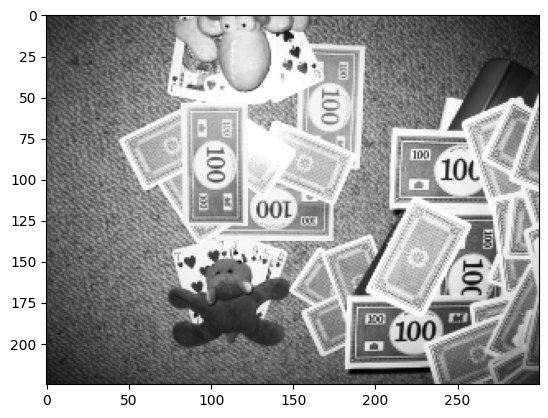

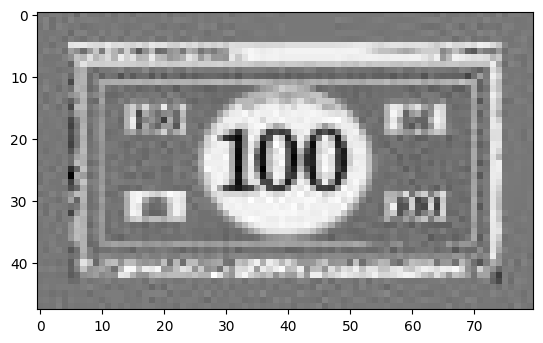

Hough votes


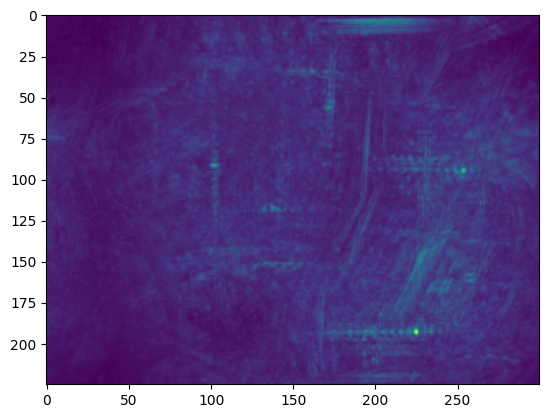

Filtered Hough votes


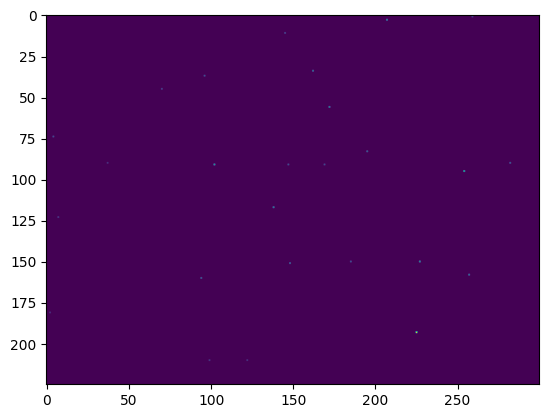

Detected Positions
148 151
162 34
138 117
257 158
172 56
225 193
207 3
102 91
254 95
227 150


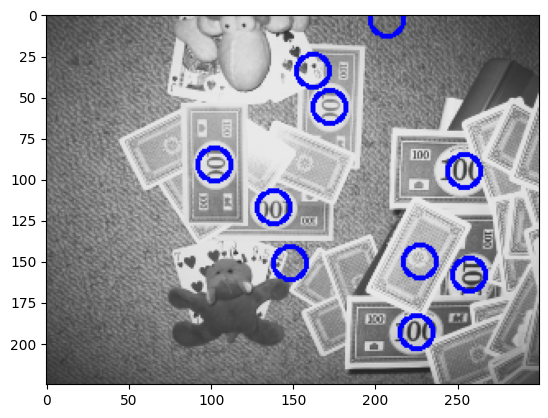

In [2]:
# Load query image and template 
query = cv2.imread("data/query.jpg", cv2.IMREAD_GRAYSCALE)
template = cv2.imread("data/template.jpg", cv2.IMREAD_GRAYSCALE)

# Visualize images
utils.show(query)
utils.show(template)

# Create search space and compute GHT
angles = np.linspace(0, 360, 36)
scales = np.linspace(0.9, 1.3, 10)
ght = GeneralizedHoughTransform(query, template, angles, scales)

# extract votes (correlation) and parameters
votes, thetas, s = zip(*ght)

# Visualize votes
print("Hough votes")
votes = np.stack(votes).max(0)
plt.imshow(votes)
plt.show()

# nonMaxSuprression
print("Filtered Hough votes")
votes = nonMaxSuprression(votes, 20)
plt.imshow(votes)
plt.show()

# Visualize n best matches
n = 10
coords = zip(*np.unravel_index(np.argpartition(votes, -n, axis=None)[-n:], votes.shape))
vis = np.stack(3*[query],2)
print("Detected Positions")
for y,x in coords:
    print(x,y)
    vis = cv2.circle(vis,(x,y), 10, (255,0,0), 2)
utils.show(vis)


# Test your implementation

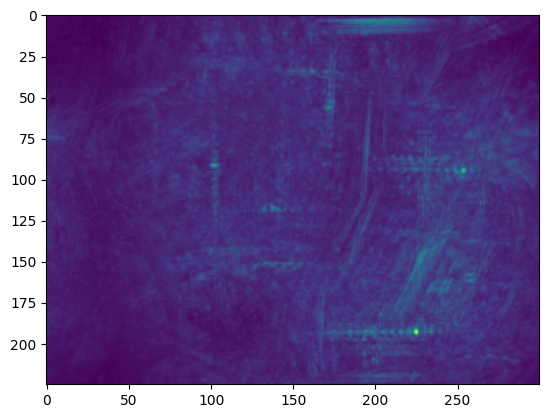

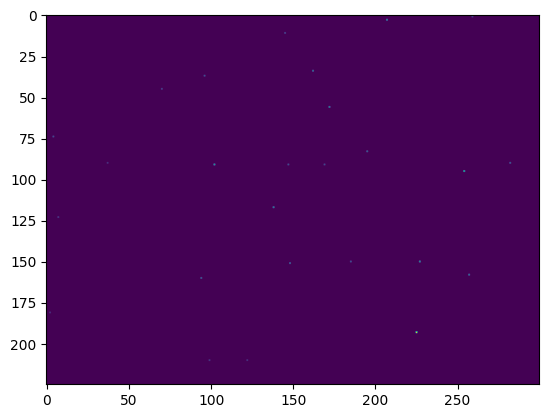

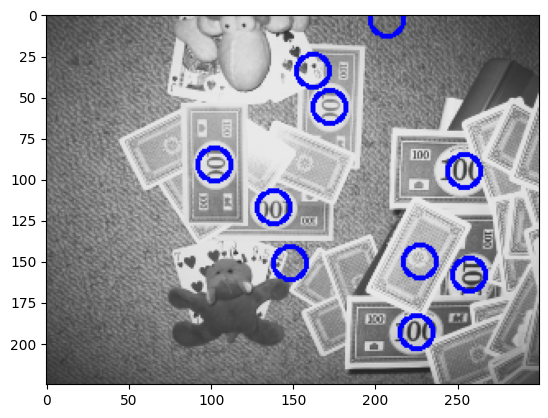

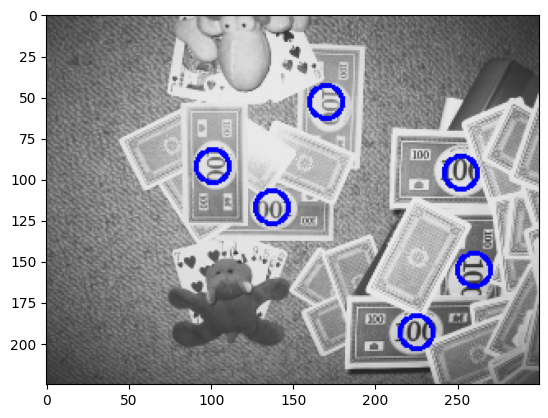

{"scores": {"Correct_Detections": 6}}


In [3]:
import utils
import cv2
import json
from matplotlib import pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances


def testGHT():
    # Load Images
    query = cv2.imread("data/query.jpg", cv2.IMREAD_GRAYSCALE)
    template = cv2.imread("data/template.jpg", cv2.IMREAD_GRAYSCALE)
    
    # GHT with search space
    angles = np.linspace(0, 360, 36)
    scales = np.linspace(0.9, 1.3, 10)
    ght = GeneralizedHoughTransform(query, template, angles, scales)
    
    # Visualize GHT votes
    votes, thetas, s = zip(*ght)
    votes = np.stack(votes).max(0)
    plt.imshow(votes)
    plt.show()

    # Visualize filtered points
    votes = nonMaxSuprression(votes, 20)
    plt.imshow(votes)
    plt.show()

    # Extract n points wiht highest voting score
    n = 10
    coords = list(zip(*np.unravel_index(np.argpartition(votes, -n, axis=None)[-n:], votes.shape)))
    vis = np.stack(3*[query],2)
    for y,x in coords:
        vis = cv2.circle(vis,(x,y), 10, (255,0,0), 2)
    utils.show(vis)

    # Compare with ground-truth centroids
    f = open("centroids.txt", "r")
    centroids = f.read()
    f.close()
    centroids = centroids.split("\n")[:-1]
    centroids = [centroid.split() for centroid in centroids]
    centroids = np.array([[int(centroid[0]),int(centroid[1])] for centroid in centroids])
    
    # Visualize centroids
    vis = np.stack(3*[query],2)
    for x,y in centroids:
        vis = cv2.circle(vis,(x,y), 10, (255,0,0), 2)
    utils.show(vis)
    
    # Compute Distances and apply threshold
    coords = np.array(coords)[:,::-1]
    d = euclidean_distances(centroids, coords).min(1)
    correct_detections = np.count_nonzero((d<10))
    score = { "scores": {"Correct_Detections": correct_detections }}
    
    print(json.dumps(score))

testGHT()